# 389 Final Project
By: Donald, Jacob, and Phirrep

In [1]:
# Step 1: Let's import some libraries and say hi!

import numpy as np     # <----- Our old friend

import torch            # |  Our new best friends -- this is the main pytroch library
import torch.nn as nn   # |  This is just shortening the name of this module since we're gonna use it a lot -- this is the one that has neural network objects (nn.modules)
import torchvision      # |  This is for importing the vision datasets we'll use
from torch.utils.data import Dataset, DataLoader, random_split, Subset # | These are particular objects that we use to load our data (and shuffle it and whatnot) we'll talk more about these later
import torchvision.transforms as tt # | Allows us to transform our data while we load it (or after) such as rotating, flipping, ocluding, etc. 
from torchvision.datasets import ImageFolder # | ^^ less important for you


import torch.nn.functional as F # | This is for functional / in-place operations for example if I wanted to do a sigmoid operation, but not as a neural net object (though I can still update through it)



from torchvision.utils import make_grid  # |   Utility stuff for plotting
import matplotlib.pyplot as plt          # |  <- I use this one a lot for plotting, seaborn is a good alternative
from matplotlib.image import imread      # |  it reads images... (png -> usable input (like a numpy array for ex))
import os
import random
from tqdm import tqdm  # | This one is a cute one for making a loading bar, I like it and we'll use it here


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images_folder, labels_file, transform=None):
        self.images_folder = images_folder
        self.labels = self.read_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name, label = self.labels[idx]
        image_path = os.path.join(self.images_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def read_labels(self, labels_file):
        labels = []
        with open(labels_file, 'r') as file:
            count = 0
            for line in file:
                parts = line.strip().split()  # Assuming each line has image name and label separated by space
                label = float(parts[1])  # Assuming labels are integers
                labels.append((f"frame_{count:04d}.png", label))
                count += 1
        return labels

def loaddataset(batch_size):
    images_folder = "vid0_frames"
    labels_file = "labeled/0.txt"
    transform = None  # You can define transformations here if needed (e.g., torchvision.transforms.ToTensor())

    transform = transforms.Compose([
    transforms.Resize((109, 146)),  # Resize image to a square 256x256
    transforms.ToTensor()  # Convert image to tensor
    ])

    dataset = CustomDataset(images_folder, labels_file, transform)

# Create a DataLoader to iterate over the dataset

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader



In [3]:
def plot_image_and_label(image, label):
    
    '''
    Takes in an image and label and shows them using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    image = image.permute(1, 2, 0)

    plt.imshow(image)
    plt.title("Label = " + str(label))
    plt.show()
    return

torch.Size([3, 109, 146])


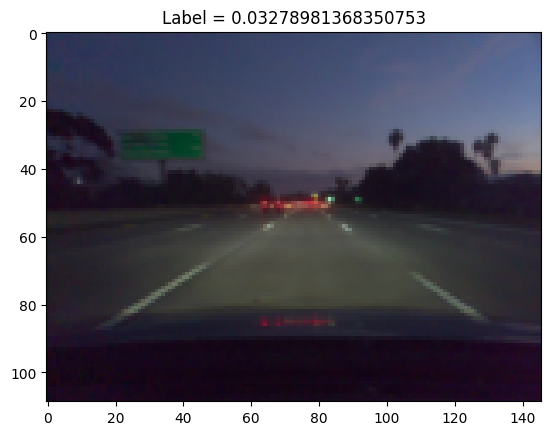

In [4]:
train_dataset, train_dataloader = loaddataset(batch_size=1)
ex_image, ex_label = train_dataset[random.randint(0,1000)]
print(ex_image.shape)
plot_image_and_label(ex_image, ex_label)

In [5]:
class MyMLP(nn.Module):

    '''
    Now that you're an expert in pytorch you can make a slightly more serious model

    You can include as many linear layers as you'd like (I used 3 in my testing), but make sure to have a ReLU
    in between each (but not at the end)

    I also included a SoftMax (which acts similarly to a max but returns values which add up to 1 -- 
    and is differentiable) at the end of the model to allow it to compare to MNIST labels
    '''


    def __init__(self, input_size, output_size):
        super(MyMLP, self).__init__()

        self.input_size = input_size # making the input size accessible

        # TODO initalize your layers here 
        # that makes up the model -- use nn.Linear and nn.ReLU
        # this would be convention of what we would need to init for a 3 layer network with nonlinearities
        # Note that I onlt defined one nonlinearity (cause they dont have parameters)
        #################################

        self.lin1 = nn.Linear(input_size,2000)
        self.lin2 = nn.Linear(2000,700)
        self.lin3 = nn.Linear(700,100)

        self.lin4 = nn.Linear(100,1)

        self.relu = nn.ReLU()

        #################################


    def forward(self, x):

        x = x.view(-1, self.input_size)   # This reshapes the input to work with the batches

        # TODO perform the forward pass of you model 
        # use the modules you initialized above (each should be used)
        #################################

        out = self.lin1(x)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.relu(out)
        out = self.lin3(out)
        out = self.relu(out)
        out = self.lin4(out)

        #################################

        return out

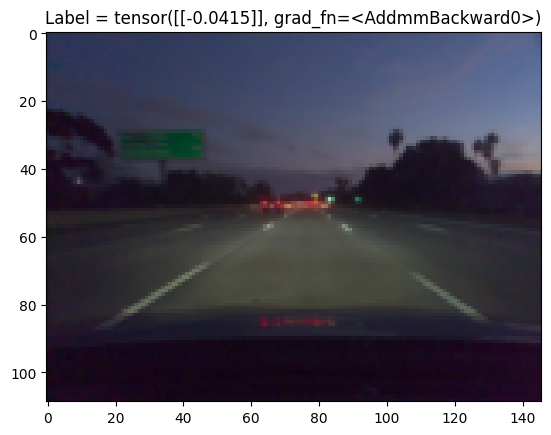

In [6]:
# Shows the prediction of the model without training
# Not very good huh? (though theres a small chance it is lol)

test_model = MyMLP(47742,1)
test_output = test_model(ex_image.flatten()) # Notice how we flatten the 2d image into 1d to use the MLP

plot_image_and_label(ex_image, test_output)

In [7]:
## Fill in the loss_function and optimizer below and run this cell to see if they are valid!

model = MyMLP(47742, 1)                                        ## This is your model, no need to change this

# TODO fill out the loss_function and optimizer

#############################################

loss_function = torch.nn.L1Loss()               ## You should use CrossEntropyLoss, use the API to decide how to define this 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)                            ## You can use SGD for this, which is defined in torch.optim -- look up some API stuff

#############################################





In [8]:
# training function here

def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):

    '''
    Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function

    This will iterate over the dataloader 'n_epochs' times training on each batch of images
    
    To get the gradient (which is stored internally in the model) use .backward() from the loss tensor
    and to apply it use .step() on the optimizer

    In between steps you need to zero the gradient so it can be recalculated -- use .zero_grad for this
    '''
    
    losses = []

    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step

            ##############################################################

            optimizer.zero_grad()

            output = model(image)


            loss = abs(output - label)

            loss.backward()

            optimizer.step()





            ##############################################################
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses



In [11]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

def forward(self, predictions, targets):
    return 100000*torch.mean((predictions - targets) ** 2)

100%|██████████| 1200/1200 [01:58<00:00, 10.16it/s]


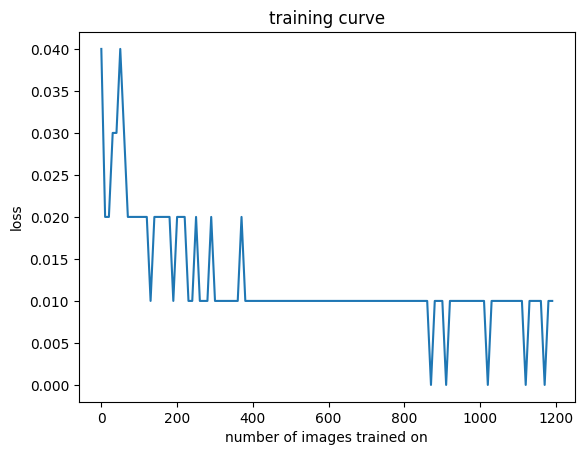

In [12]:
# Plug in your model, loss function, and optimizer 
# Try out different hyperparameters and different models to see how they perform

lr = 0.02               # The size of the step taken when doing gradient descent
batch_size = 1        # The number of images being trained on at once
update_interval = 10   # The number of batches trained on before recording loss
n_epochs = 1            # The number of times we train through the entire dataset

train_dataset, train_dataloader = loaddataset(batch_size=batch_size)

model = MyMLP(47742, 1)
loss_function = CustomMSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()
